In [1]:
import logging
from sentinelhub import DataCollection
from sentinelhub import SHConfig
from sentinel_api import sentinel_single_image, sentinel_territory
import numpy as np
from PIL import Image
import os

### Logging in sentinel account

In [2]:
logging.basicConfig(level=logging.INFO)

# Your client credentials
client_id = 'e0b127dc-fbb5-4151-8946-96d8728003c7'
client_secret = '4Xy2[Bc#?&L!xbha(XB6*%Xbry,BU-cZA0Dd9n,W'

config = SHConfig(instance_id='',
         sh_client_id = client_id,
         sh_client_secret = client_secret,
         sh_base_url='https://services.sentinel-hub.com',
         sh_token_url='https://services.sentinel-hub.com/oauth/token',)

### Download an image from Sentinel-hub API (fn: sentinel_single_image)

In [ ]:
# fn input
bbox = [58.50, 23.65, 58.60, 23.75]
timeline = ('2023-07-05', '2023-09-25')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

img = sentinel_single_image(bbox, timeline, config=config, data_collection=data_collection_modes[1], mosaicking_order = mosaicking_order_modes[0],
                            resolution=10, maxcc=0.8, img_size=(2500,2500), return_numpy=False, verbose=True, save_image=False, save_dir="sentinel-hub")
img.save(r"C:\Users\user2\Desktop\sentinel-3.png")
img

### Download images of a vast area from Sentinel-hub API (fn: sentinel_territory)

#### In disk

In [ ]:
# fn inputs:
bbox_coords = [58.5, 23.6, 59, 24.1]
bbox_coords = [58.5, 23.6, 58.8, 23.9]
timeline = ('2023-07-05', '2023-09-25')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

final_image = sentinel_territory(bbox_coords, timeline, config, data_collection=data_collection_modes[1], mosaicking_order = 'mostRecent', maxcc=0.8,
                                resolution=5, img_size=(2500, 2500), save_concat_image=True, in_memory=False, temp_dir=r"sentinel-tmp",
                                concat_image_dir=r"sentinel-concat", concat_image_name="default", delete_temp=True)

#### In memory

In [3]:
# fn inputs
bbox_coords = [58.7, 23.6, 58.9, 23.8]
timeline = ('2023-07-05', '2023-09-25')

# Parameters
mosaicking_order_modes = ['mostRecent', 'leastCC', 'leastRecent']
data_collection_modes = [DataCollection.SENTINEL2_L2A, DataCollection.SENTINEL2_L1C]

concat_image = sentinel_territory(bbox_coords, timeline, config, data_collection=data_collection_modes[1], mosaicking_order = 'mostRecent', maxcc=0.8,
                      resolution=5, img_size=(2500,2500), lon_lat_step=(0.05, 0.05), in_memory=True, save_concat_image=True,
                      concat_image_dir=r"sentinel-concat", concat_image_name="default", delete_temp=False)

Territory dimensions: 20,379m x 22,239m | Area: 453 km^2
Concatenated image will be in size of 9999 x 9999 p
There are 16 bboxes to download



dl from sentinel-hub | bbox: [58.85, 23.75, 58.9, 23.8]: 100%|█████████████████████████| 16/16 [03:16<00:00, 14.72s/it]

All images are downloaded into memory - concatenating images is in progress...
Done!


dl from sentinel-hub | bbox: [58.85, 23.75, 58.9, 23.8]: 100%|█████████████████████████| 16/16 [03:16<00:00, 12.31s/it]

concatenated image saved in sentinel-concat


### Integrated Inference (sentinel and inference modules integration)

In [4]:
print(type(concat_image))
print(concat_image.size)

<class 'PIL.Image.Image'>
(10000, 10000)


In [5]:
from inference_modular import ship_detection
from PIL import Image
# images_path = r"D:\NLP 1\Sat_object_detection\inference_images"
# images_path = r"D:\NLP 1\Sat_object_detection\debug_images_2\e7e24507a.jpg"
# images_path = r"D:\NLP 1\Sat_object_detection\sentinel-concat\2023-07-05_2023-09-25-[58.5, 23.6, 58.7, 23.8]-res5-(2500, 2500)-mostRecent-sentinel-2-l1c-maxcc0.8.jpg"
# images_path = r"D:\NLP 1\Sat_object_detection\sentinel-concat\2023-07-05_2023-09-25-[58.7, 23.6, 58.9, 23.8]-res5-(2500, 2500)-mostRecent-sentinel-2-l1c-maxcc0.8.jpg"
images_path = r"D:\NLP 1\Sat_object_detection\sentinel-concat\2023-07-05_2023-09-25-[58.5, 23.6, 58.7, 23.8]-res5-(2500, 2500)-mostRecent-sentinel-2-l1c-maxcc0.8.jpg"
img = Image.open(images_path)
bbox_coords = [58.7, 23.6, 58.9, 23.8]

result_pred = ship_detection(images=img, bbox_coord_wgs84=bbox_coords, annotations=["score", "length", "coord"], nms_iou_threshold=0.15, scale_down_factor= 7,
                        adaptive_scale_down_parameters = {'a': 0.3, 'b': 1, 'threshold': 1.5}, confidence_threshold=0.85, sahi_overlap_ratio=0.05,
                        output_annotated_image=True, save_annotated_image=False, output_original_image=True
                        # , output_dir=r"D:\NLP 1\Sat_object_detection\sentinel-concat",
                        # output_name="prediction", annotation_font_size=12, annotation_font=r"calibri.ttf", annotation_bbox_width=1,
                        )



The model takes a while to load for the first inference.
Processing prediction
Performing prediction on 6 number of slices.
6 bboxes found in prediction


In [6]:
result_pred

{'n_obj': 6,
 'bboxes': array([[ 249.235  ,  947.739  ,  275.33334,  962.76166],
        [ 317.55228, 1056.1848 ,  344.221  , 1071.1578 ],
        [ 593.75336, 1150.9622 ,  603.62494, 1157.2019 ],
        [ 898.65393, 1190.3652 ,  906.53894, 1198.9167 ],
        [ 782.12946, 1371.9961 ,  787.38074, 1379.7988 ],
        [ 644.44794, 1136.1881 ,  649.08246, 1146.1648 ]], dtype=float32),
 'scores': array([0.99055403, 0.977612  , 0.9537238 , 0.935274  , 0.9160168 ,
        0.8612735 ], dtype=float32),
 'original_image': <PIL.Image.Image image mode=RGB size=1785x1428>,
 'ships_long_lat': [(58.729387583158, 23.733788566696),
  (58.737074135318, 23.748973583574),
  (58.767080016577, 23.761636138831),
  (58.801131253283, 23.767316665436),
  (58.787927745317, 23.792702725622),
  (58.772466688824, 23.759828643371)],
 'ships_lengths': [378.9, 383.5, 148.8, 160.8, 135.5, 164.2],
 'ships_bbox_dimensions': [(298.0, 234.0),
  (304.5, 233.2),
  (112.7, 97.2),
  (133.2, 90.0),
  (121.5, 60.0),
  (155.4

In [14]:
result_pred

{'n_obj': 6,
 'bboxes': array([[ 249.235  ,  947.739  ,  275.33334,  962.76166],
        [ 317.55228, 1056.1848 ,  344.221  , 1071.1578 ],
        [ 593.75336, 1150.9622 ,  603.62494, 1157.2019 ],
        [ 898.65393, 1190.3652 ,  906.53894, 1198.9167 ],
        [ 782.12946, 1371.9961 ,  787.38074, 1379.7988 ],
        [ 644.44794, 1136.1881 ,  649.08246, 1146.1648 ]], dtype=float32),
 'scores': array([0.99055403, 0.977612  , 0.9537238 , 0.935274  , 0.9160168 ,
        0.8612735 ], dtype=float32),
 'original_image': <PIL.Image.Image image mode=RGB size=1785x1428>,
 'ships_long_lat': [(58.729387583158, 23.733788566696),
  (58.737074135318, 23.748973583574),
  (58.767080016577, 23.761636138831),
  (58.801131253283, 23.767316665436),
  (58.787927745317, 23.792702725622),
  (58.772466688824, 23.759828643371)],
 'ships_lengths': [378.9, 383.5, 148.8, 160.8, 135.5, 164.2],
 'ships_bbox_dimensions': [(298.0, 234.0),
  (304.5, 233.2),
  (112.7, 97.2),
  (133.2, 90.0),
  (121.5, 60.0),
  (155.4

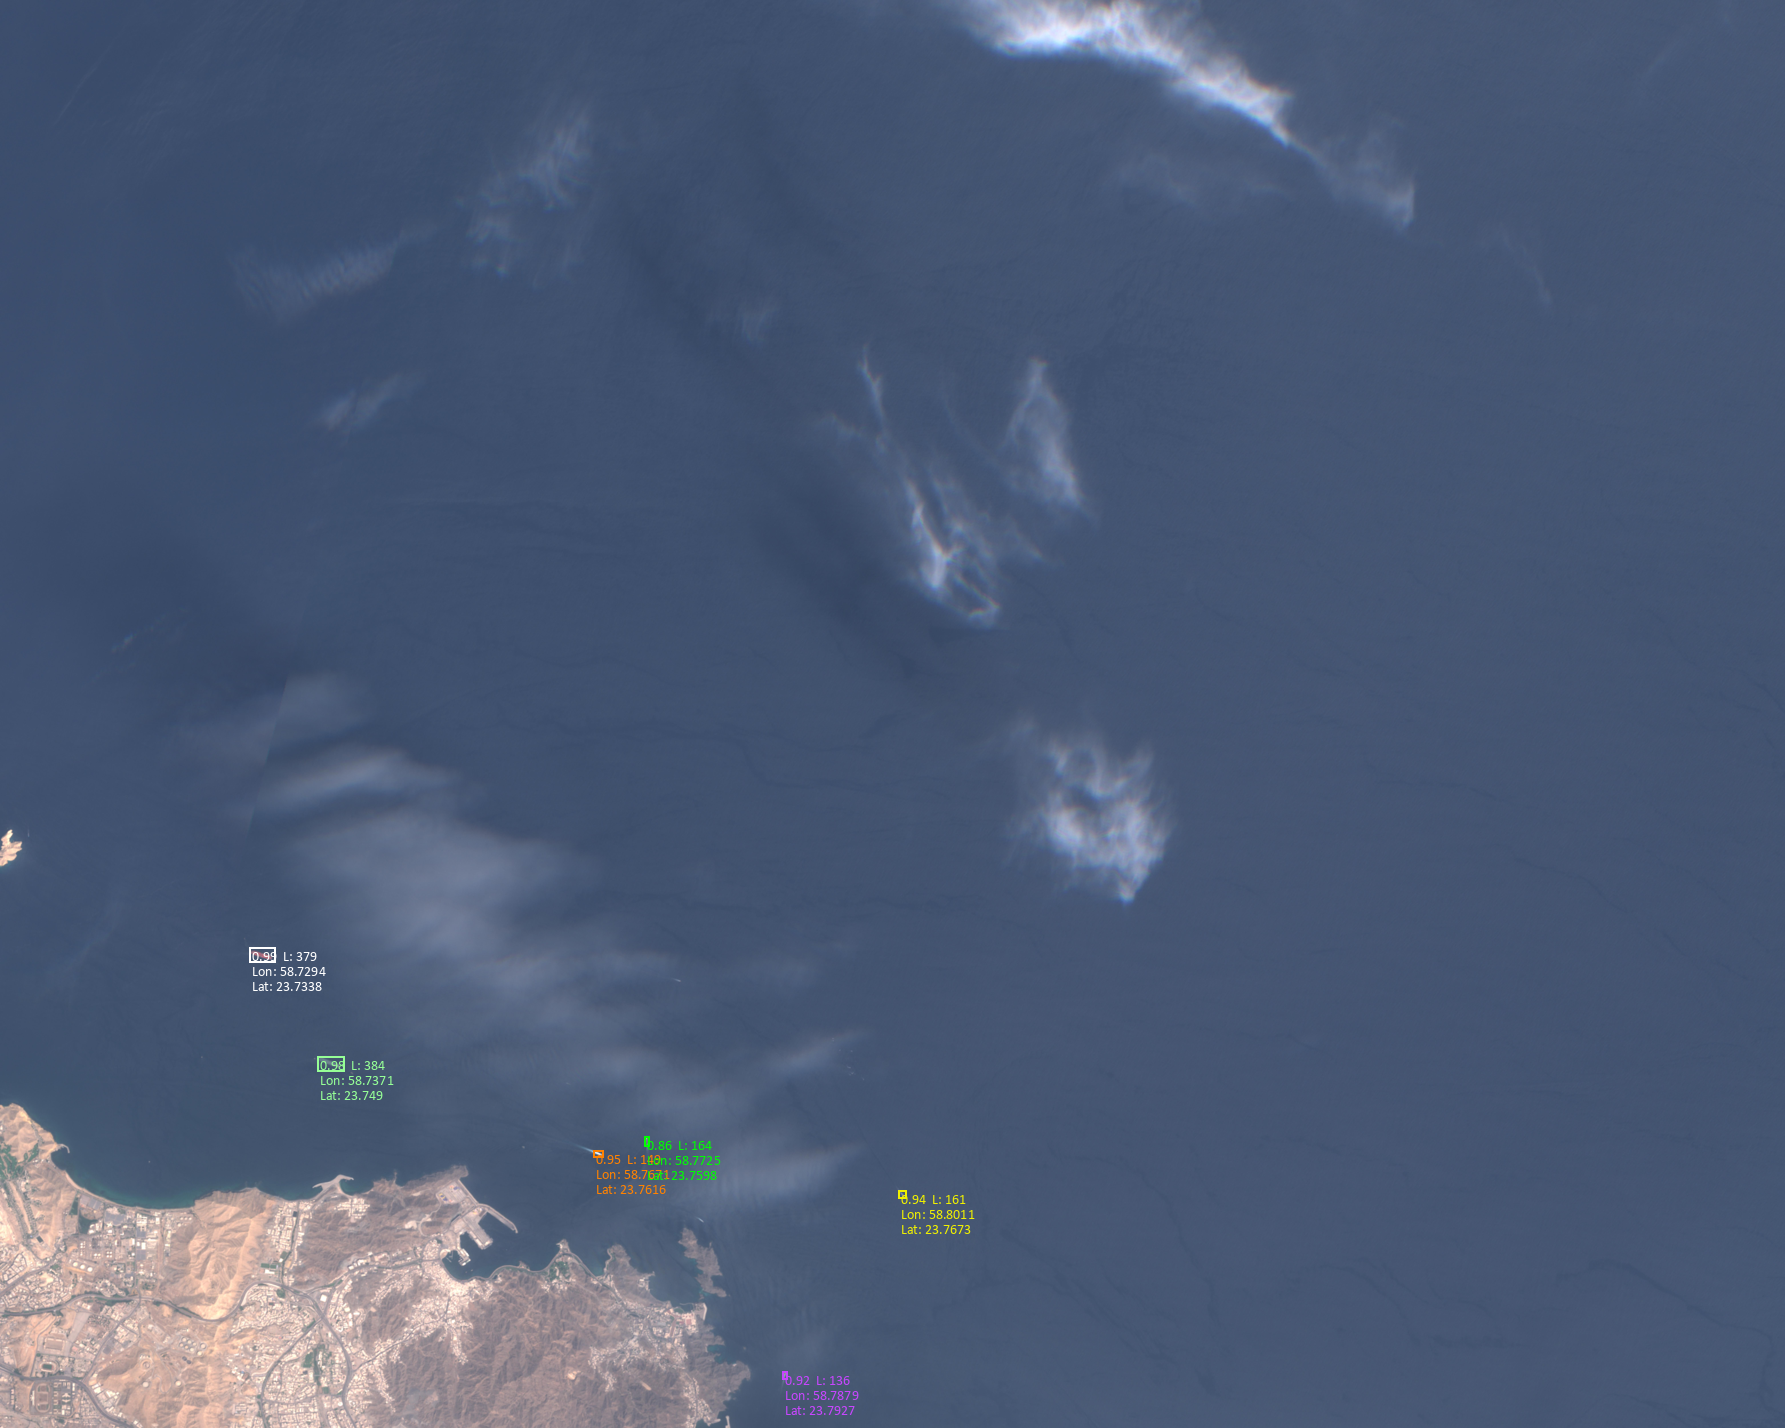

In [5]:
# result_pred["original_image"]
result_pred["annotated_image"]

In [ ]:
from PIL import Image
images_path = r"D:\NLP 1\Sat_object_detection\sentinel-concat\2023-07-05_2023-09-25-[58.5, 23.6, 59, 24.1]-res5-(2500, 2500)-mostRecent-sentinel-2-l1c-maxcc0.8.jpg"
img = Image.open(images_path)

### Drafts